In [302]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [303]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40475 entries, 0 to 40474
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     40475 non-null  object 
 1   description               40475 non-null  object 
 2   summary                   40463 non-null  object 
 3   installs                  40475 non-null  object 
 4   minInstalls               40475 non-null  float64
 5   score                     40475 non-null  float64
 6   ratings                   40475 non-null  float64
 7   reviews                   40475 non-null  float64
 8   histogram                 40475 non-null  object 
 9   price                     40475 non-null  float64
 10  free                      40475 non-null  int64  
 11  currency                  40475 non-null  object 
 12  sale                      40475 non-null  bool   
 13  offersIAP                 40475 non-null  bool   
 14  inAppP

In [304]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [305]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [306]:
df = df[df['minInstalls'] == 1000000]

In [307]:
df = df[(df['year'] < 2021)]

In [308]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [309]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr,test_size=.20, random_state=10)

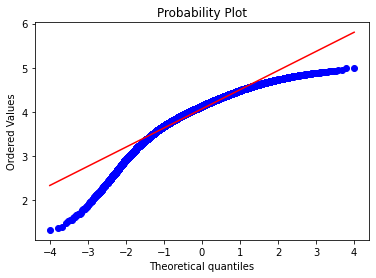

In [310]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 22158
- Mean of distribution of rating : 4.068657300252703
- Standard deviation: 0.449417053871379


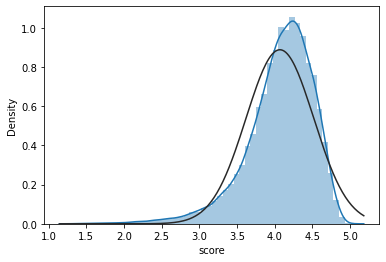

In [311]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

In [312]:
df.groupby('year')['score'].min()

year
2010    1.809032
2011    1.626476
2012    1.652318
2013    1.324779
2014    1.541436
2015    1.492308
2016    1.589474
2017    1.628866
2018    1.851852
2019    1.696825
2020    1.402204
Name: score, dtype: float64

In [313]:
df.groupby('year')['year'].count()

year
2010     343
2011     863
2012    1155
2013    1488
2014    2244
2015    2425
2016    2835
2017    3325
2018    3078
2019    2986
2020    1416
Name: year, dtype: int64

## Testing with pipeline

In [314]:
## Define pipeline transformers 

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',sparse='false'))])

In [315]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [316]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear', LinearRegression())])

In [317]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse='false'))]),
                                                  Index(['genre', 'contentRating'], dtype='object'))])),
                ('linear', LinearRegression())])

In [318]:
y_pred = lr.predict(X_val)

In [319]:
lr.score(X_val,y_val)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.40
MSE of linear regression on val set: 0.34


In [320]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val.columns, lr['linear'].coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.11
free : 0.01
containsAds : 0.00
genre : 0.00
editorsChoice : -0.02
contentRating : 0.06
year : 0.01
top_developer : -0.03
installs_day : 0.02
updated_days : 0.22
has_video : -0.12
compound : -0.00


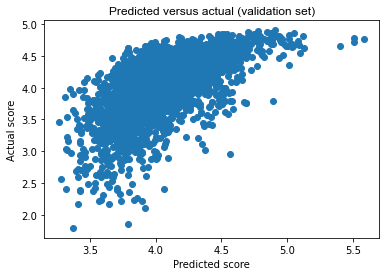

In [321]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

## No pipeline

In [322]:
X_train_cont = X_train[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont = X_val[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [323]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[['genre','contentRating']])

ohe_x_train = ohe.transform(X_train[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_train_df = pd.DataFrame(ohe_x_train, columns=columns, index=X_train.index)

In [324]:
ohe_v = OneHotEncoder(drop='first', sparse=False)

ohe_v.fit(X_val[['genre','contentRating']])

ohe_x_val = ohe_v.transform(X_val[['genre','contentRating']])

columns_v = ohe_v.get_feature_names(['genre','contentRating'])

ohe_x_val_df = pd.DataFrame(ohe_x_val, columns=columns_v, index=X_val.index)

In [325]:
#Merge cont and cat DFs
combo_train_df = pd.concat([X_train_cont, ohe_x_train_df], axis=1)

combo_val_df =  pd.concat([X_val_cont, ohe_x_val_df], axis=1)

In [326]:
lr = LinearRegression()

lr.fit(combo_train_df, y_train)

y_pred = lr.predict(combo_val_df)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(combo_val_df, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.36


In [327]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df.columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
containsAds : -0.02
editorsChoice : 0.14
year : -0.01
top_developer : 0.48
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.19
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.15
genre_Board : 0.10
genre_Books & Reference : 0.11
genre_Business : 0.14
genre_Card : 0.21
genre_Casino : 0.26
genre_Casual : -0.04
genre_Comics : -0.10
genre_Communication : 0.02
genre_Dating : -0.03
genre_Education : -0.00
genre_Entertainment : -0.08
genre_Events : -0.09
genre_Finance : 0.13
genre_Food & Drink : 0.21
genre_Health & Fitness : 0.13
genre_House & Home : 0.05
genre_Libraries & Demo : 0.02
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.11
genre_Medical : -0.02
genre_Music : -0.05
genre_Music & Audio : 0.05
genre_News & Magazines : 0.01
genre_Parenting : 0.06
genre_Personalization : 0.09
genre_Photography : -0.08
genre_Productivity : 0.09
genre_Puzzle : 0.12
ge

In [328]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(combo_val_df)
check['resid'] = check['pred'] - check['score']

In [329]:
check.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
18367,17466.0,1,1,Lifestyle,0,Everyone,2010,0,265.816055,362,0,0.023662,1.850772,3.803949,1.953177
2434,22315.0,1,1,Lifestyle,0,Everyone,2010,0,266.311585,75,0,0.106293,2.106250,3.920866,1.814616
35720,3864.0,1,0,Sports,0,Teen,2015,0,490.436488,30,1,0.189173,2.216495,4.007843,1.791348
19148,6694.0,1,0,Tools,0,Everyone,2012,0,331.785003,507,0,0.073192,2.231689,3.900317,1.668628
37870,3593.0,1,1,Personalization,0,Everyone,2020,0,2932.551320,290,0,0.665996,2.961111,4.579105,1.617994
13882,6727.0,1,1,Entertainment,0,Everyone,2014,0,389.559797,15,0,-0.223204,1.794643,3.401531,1.606888
2564,16883.0,1,1,Tools,0,Everyone,2019,0,1519.756839,23,1,0.033283,2.269458,3.861159,1.591702
24791,41818.0,1,1,Entertainment,0,Teen,2013,0,344.946533,7,0,0.277861,2.405864,3.993814,1.587949
2508,15063.0,1,0,Music & Audio,0,Everyone,2015,0,450.045005,726,0,-0.014379,2.213104,3.738143,1.525039
22469,14008.0,1,0,Business,0,Everyone,2010,0,264.620270,6,0,-0.095042,2.358464,3.842108,1.483644


In [330]:
check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
26949,22892.0,1,1,Casino,0,Teen,2019,0,2217.294900,30,0,0.302064,4.265358,4.315809,0.050451
3103,11795.0,1,1,Photography,0,Everyone,2019,1,2118.644068,116,0,0.404884,4.688944,4.590993,-0.097951
33633,2960.0,1,1,Arcade,0,Everyone,2017,0,809.061489,85,0,0.146363,3.891892,3.899017,0.007125
31339,8874.0,1,1,Sports,0,Everyone,2019,0,1310.615990,53,0,0.044710,3.694878,3.732023,0.037146
23726,5646.0,1,0,Entertainment,0,Everyone,2019,0,1386.962552,11,0,-0.052809,3.672474,3.573526,-0.098948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20952,8669.0,1,1,Action,0,Teen,2018,0,1035.196687,439,1,-0.092053,3.612903,3.617911,0.005008
1038,15201.0,1,1,Video Players & Editors,0,Everyone,2019,0,1342.281879,725,0,-0.074102,3.585398,3.488420,-0.096977
33653,34378.0,1,0,Business,0,Everyone,2015,0,517.330574,26,0,-0.055120,3.918285,3.826476,-0.091809
29263,10034.0,1,1,Music,0,Everyone,2018,0,1021.450460,27,1,0.244804,3.940417,4.014946,0.074529


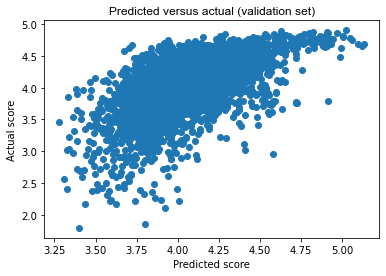

In [331]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

Specifically, way over predicting the lower scoring apps - typically earleir years

## Testing with apps below 2.5 score dropped

In [332]:
df_copy = df.copy()
df_copy = df_copy[df_copy['score'] >= 2.5]

In [333]:
X2 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video','compound']]

y2 = df_copy['score']

In [334]:
# Split to create temporary tr and test 
X_tr2, X_test2, y_tr2, y_test2 = train_test_split(X2, y2,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_tr2, y_tr2,test_size=.20, random_state=10)

In [335]:
X_train_cont2 = X_train2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont2 = X_val2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [336]:
ohe2 = OneHotEncoder(drop='first', sparse=False)

ohe2.fit(X_train2[['genre','contentRating']])

ohe_x_train2 = ohe2.transform(X_train2[['genre','contentRating']])

columns2 = ohe2.get_feature_names(['genre','contentRating'])

ohe_x_train_df2 = pd.DataFrame(ohe_x_train2, columns=columns2, index=X_train2.index)

In [337]:
ohe_v2 = OneHotEncoder(drop='first', sparse=False)

ohe_v2.fit(X_val2[['genre','contentRating']])

ohe_x_val2 = ohe_v2.transform(X_val2[['genre','contentRating']])

columns_v2 = ohe_v2.get_feature_names(['genre','contentRating'])

ohe_x_val_df2 = pd.DataFrame(ohe_x_val2, columns=columns_v2, index=X_val2.index)

In [338]:
#Merge cont and cat DFs
combo_train_df2 = pd.concat([X_train_cont2, ohe_x_train_df2], axis=1)

combo_val_df2 =  pd.concat([X_val_cont2, ohe_x_val_df2], axis=1)

In [339]:
lr2 = LinearRegression()

lr2.fit(combo_train_df2, y_train2)

y_pred2 = lr2.predict(combo_val_df2)
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(combo_val_df2, y_val2)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val2, y_pred2))))

R^2 of linear regression on val set: 0.34
MSE of linear regression on val set: 0.33


In [340]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df2.columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
containsAds : -0.04
editorsChoice : 0.16
year : -0.01
top_developer : 0.48
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.07
genre_Adventure : -0.10
genre_Arcade : 0.03
genre_Art & Design : 0.02
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.11
genre_Board : 0.09
genre_Books & Reference : 0.15
genre_Business : 0.16
genre_Card : 0.22
genre_Casino : 0.26
genre_Casual : -0.02
genre_Comics : -0.11
genre_Communication : 0.10
genre_Dating : 0.06
genre_Education : 0.03
genre_Entertainment : -0.04
genre_Events : -0.09
genre_Finance : 0.20
genre_Food & Drink : 0.14
genre_Health & Fitness : 0.16
genre_House & Home : 0.14
genre_Libraries & Demo : -0.14
genre_Lifestyle : 0.03
genre_Maps & Navigation : 0.12
genre_Medical : 0.07
genre_Music : 0.03
genre_Music & Audio : 0.10
genre_News & Magazines : 0.07
genre_Parenting : 0.11
genre_Personalization : 0.12
genre_Photography : -0.04
genre_Productivity : 0.11
genre_Puzzle : 0.14
genre_R

In [341]:
check2 = X_val2.copy()
check2['score'] = y_val2
check2['pred'] = lr2.predict(combo_val_df2)
check2['resid'] = check2['pred'] - check2['score']

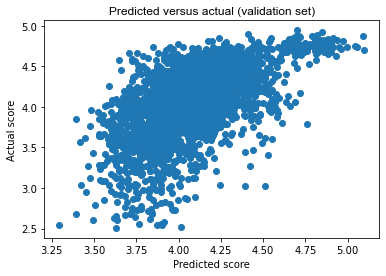

In [342]:
fig, ax = plt.subplots()
plt.scatter(y_pred2,y_val2)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

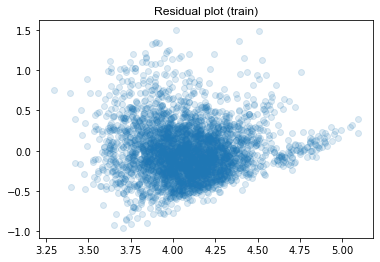

In [343]:
plt.scatter(check2['pred'],check2['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);

In [344]:
small_cluster_df = check2[check2['pred'] >= 4.5]

In [345]:
check2.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,compound,score,pred,resid
top_developer,,,,,,,,,,,,,,
0,3409,3409,3409,3409,3409,3409,3409,3409,3409,3409,3409,3409,3409,3409
1,107,107,107,107,107,107,107,107,107,107,107,107,107,107


In [346]:
small_cluster_df.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,compound,score,pred,resid
top_developer,,,,,,,,,,,,,,
0,67,67,67,67,67,67,67,67,67,67,67,67,67,67
1,99,99,99,99,99,99,99,99,99,99,99,99,99,99


In [347]:
check2.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
37022,5214.0,1,0,Finance,0,Everyone,2011,0,282.645562,1,0,-0.012371,2.518164,4.015370,1.497205
28864,2951.0,1,1,Entertainment,0,Everyone,2014,0,423.011844,259,0,0.757395,3.020270,4.508781,1.488510
29557,1940.0,1,0,Education,0,Everyone,2017,0,678.886626,469,0,0.593195,3.025773,4.389634,1.363861
2080,10019.0,1,0,Tools,0,Everyone,2012,0,321.750322,728,0,0.036445,2.546361,3.899357,1.352996
25197,10357.0,1,0,Books & Reference,0,Everyone,2011,0,283.848992,22,0,-0.073546,2.553640,3.895879,1.342239
13915,5963.0,1,0,Arcade,0,Everyone,2013,0,351.370344,747,1,0.051748,2.575251,3.915990,1.340739
11702,2151.0,1,1,Tools,0,Teen,2017,0,687.757909,130,0,0.076110,2.543779,3.874685,1.330906
39464,13748.0,1,0,Entertainment,0,Everyone,2011,0,280.112045,544,1,0.144356,2.723312,3.979038,1.255727
17909,8882.0,1,0,Health & Fitness,0,Everyone,2017,0,846.740051,12,0,0.043964,2.730337,3.963970,1.233633
37112,7705.0,1,1,Health & Fitness,0,Everyone,2012,0,311.235605,2306,0,0.143165,2.740597,3.958229,1.217632


## Breaking out group

In [348]:
df_analysis = check2[check2['pred'] < 4.5]

In [349]:
df_analysis

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
7640,5068.0,1,0,Art & Design,0,Everyone,2018,0,1191.895113,57,1,0.298187,3.961390,4.159690,0.198300
32526,8225.0,1,1,Casual,0,Everyone,2015,0,470.809793,604,0,0.197827,4.294404,3.900390,-0.394014
19852,1940.0,1,1,Social,0,Teen,2019,0,1949.317739,113,0,0.280080,3.882653,4.093509,0.210856
35440,14388.0,1,1,Tools,0,Everyone,2014,0,407.331976,1128,1,0.233191,4.097222,4.100107,0.002885
20320,8177.0,1,1,Health & Fitness,0,Everyone,2018,0,1074.113856,218,0,0.327488,4.607099,4.212466,-0.394633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23739,50721.0,1,0,Social,0,Teen,2015,0,482.160077,12,0,0.288786,4.499018,4.169324,-0.329694
29795,4691.0,1,1,Simulation,0,Mature 17+,2019,0,1801.801802,380,0,0.221893,4.057569,3.838139,-0.219431
11027,21809.0,1,1,Education,0,Everyone,2016,0,566.251416,805,0,0.197754,3.747986,3.921278,0.173293
24947,10265.0,1,1,Simulation,0,Everyone,2016,0,609.384522,455,1,0.452747,4.059454,4.194709,0.135255


## Testing with specific columns for genre - all apps

In [350]:
df_3 = df.copy()

In [351]:
df_3['action'] = np.where(df_3['genre'] == 'Action',1,0)
df_3['book_ref'] = np.where(df_3['genre'] == 'Books & Reference',1,0)
df_3['business'] = np.where(df_3['genre'] == 'Business',1,0)
df_3['card'] = np.where(df_3['genre'] == 'Card',1,0)
df_3['casino'] = np.where(df_3['genre'] == 'Casino',1,0)
df_3['comics'] = np.where(df_3['genre'] == 'Comics',1,0)
df_3['dating'] = np.where(df_3['genre'] == 'Dating',1,0)
df_3['education'] = np.where(df_3['genre'] == 'Education',1,0)
df_3['finance'] = np.where(df_3['genre'] == 'Finance',1,0)
df_3['food_drink'] = np.where(df_3['genre'] == 'Food & Drink',1,0)
df_3['health_fit'] = np.where(df_3['genre'] == 'Health & Fitness',1,0)
df_3['lib_demo'] = np.where(df_3['genre'] == 'Libraries & Demo',1,0)
df_3['puzzle'] = np.where(df_3['genre'] == 'Puzzle',1,0)
df_3['simulation'] = np.where(df_3['genre'] == 'Simulation',1,0)
df_3['weather'] = np.where(df_3['genre'] == 'Weather',1,0)
df_3['word'] = np.where(df_3['genre'] == 'Word',1,0)
df_3['vid_edit'] = np.where(df_3['genre'] == 'Video Players & Editors',1,0)

In [352]:
X3 = df_3[['ratings','free','containsAds','editorsChoice','contentRating','year','top_developer','installs_day',
           'updated_days','has_video','compound',
          'action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

y3 = df_3['score']

In [353]:
# Split to create temporary tr and test 
X_tr3, X_test3, y_tr3, y_test3 = train_test_split(X3, y3,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_tr3, y_tr3,test_size=.20, random_state=10)

In [354]:
X_train_cont3 = X_train3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'compound','action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

X_val_cont3 = X_val3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'compound','action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

In [355]:
ohe3 = OneHotEncoder(drop='first', sparse=False)

ohe3.fit(X_train3[['contentRating']])

ohe_x_train3 = ohe3.transform(X_train3[['contentRating']])

columns3 = ohe3.get_feature_names(['contentRating'])

ohe_x_train_df3 = pd.DataFrame(ohe_x_train3, columns=columns3, index=X_train3.index)

In [356]:
ohe_v3 = OneHotEncoder(drop='first', sparse=False)

ohe_v3.fit(X_val3[['contentRating']])

ohe_x_val3 = ohe_v3.transform(X_val3[['contentRating']])

columns_v3 = ohe_v3.get_feature_names(['contentRating'])

ohe_x_val_df3 = pd.DataFrame(ohe_x_val3, columns=columns_v3, index=X_val3.index)

In [357]:
#Merge cont and cat DFs
combo_train_df3 = pd.concat([X_train_cont3, ohe_x_train_df3], axis=1)

combo_val_df3 =  pd.concat([X_val_cont3, ohe_x_val_df3], axis=1)

In [358]:
combo_val_df3

,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,action,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen
26949,1,1,0,2019,0,2217.294900,30,0,0.302064,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
2870,1,1,0,2016,0,570.776256,1625,1,0.302643,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
27879,1,0,0,2016,0,636.942675,55,1,0.116115,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
3161,1,1,0,2013,0,337.952011,36,1,0.094496,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
23142,1,1,0,2014,0,421.229992,873,0,0.160532,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29263,1,1,0,2018,0,1021.450460,27,1,0.244804,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
12389,1,1,0,2017,0,830.564784,358,0,0.052979,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
22546,1,1,0,2018,0,1152.073733,161,1,0.617721,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
38626,1,1,0,2015,0,497.760080,160,0,0.103150,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0


In [359]:
lr3 = LinearRegression()

lr3.fit(combo_train_df3, y_train3)

y_pred3 = lr3.predict(combo_val_df3)
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(combo_val_df3, y_val3)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val3, y_pred3))))

R^2 of linear regression on val set: 0.34
MSE of linear regression on val set: 0.36


In [360]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df3.columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.04
editorsChoice : 0.13
year : -0.02
top_developer : 0.48
installs_day : 0.00
updated_days : -0.00
has_video : 0.06
compound : 1.19
action : 0.01
book_ref : 0.10
business : 0.12
card : 0.21
casino : 0.26
comics : -0.10
dating : -0.04
education : -0.01
finance : 0.10
food_drink : 0.19
health_fit : 0.12
lib_demo : 0.01
puzzle : 0.12
simulation : -0.10
weather : -0.01
word : 0.21
vid_edit : -0.08
contentRating_Everyone 10+ : 0.02
contentRating_Mature 17+ : -0.00
contentRating_Teen : -0.03


In [361]:
check3 = X_val3.copy()
check3['score'] = y_val3
check3['pred'] = lr3.predict(combo_val_df3)
check3['resid'] = check3['pred'] - check3['score']

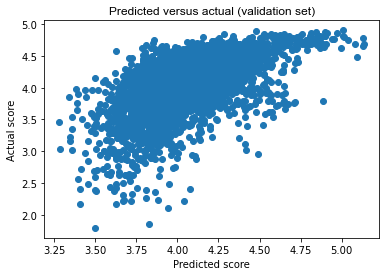

In [362]:
fig, ax = plt.subplots()
plt.scatter(y_pred3,y_val3)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

In [363]:
check3.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,score,pred,resid
18367,17466.0,1,1,0,Everyone,2010,0,265.816055,362,0,...,0,0,0,0,0,0,0,1.850772,3.825873,1.975101
2434,22315.0,1,1,0,Everyone,2010,0,266.311585,75,0,...,0,0,0,0,0,0,0,2.106250,3.944292,1.838042
35720,3864.0,1,0,0,Teen,2015,0,490.436488,30,1,...,0,0,0,0,0,0,0,2.216495,4.038843,1.822348
13882,6727.0,1,1,0,Everyone,2014,0,389.559797,15,0,...,0,0,0,0,0,0,0,1.794643,3.496525,1.701882
24791,41818.0,1,1,0,Teen,2013,0,344.946533,7,0,...,0,0,0,0,0,0,0,2.405864,4.075452,1.669588
19148,6694.0,1,0,0,Everyone,2012,0,331.785003,507,0,...,0,0,0,0,0,0,0,2.231689,3.881520,1.649831
2564,16883.0,1,1,0,Everyone,2019,0,1519.756839,23,1,...,0,0,0,0,0,0,0,2.269458,3.807636,1.538178
37870,3593.0,1,1,0,Everyone,2020,0,2932.551320,290,0,...,0,0,0,0,0,0,0,2.961111,4.491029,1.529918
2508,15063.0,1,0,0,Everyone,2015,0,450.045005,726,0,...,0,0,0,0,0,0,0,2.213104,3.717834,1.504730
22469,14008.0,1,0,0,Everyone,2010,0,264.620270,6,0,...,0,0,0,0,0,0,0,2.358464,3.861538,1.503074


## with transformed target

In [364]:
from scipy.stats import boxcox

In [365]:
X4 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video','compound']]

bcx_target,lam =boxcox(df_copy['score'])

In [366]:
len(bcx_target)

21970

In [367]:
# Split to create temporary tr and test 
X_tr4, X_test4, y_tr4, y_test4 = train_test_split(X4, bcx_target,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_tr4, y_tr4,test_size=.20, random_state=10)

In [368]:
X_train_cont4 = X_train4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont4 = X_val4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [369]:
ohe4 = OneHotEncoder(drop='first', sparse=False)

ohe4.fit(X_train4[['genre','contentRating']])

ohe_x_train4 = ohe4.transform(X_train4[['genre','contentRating']])

columns4 = ohe4.get_feature_names(['genre','contentRating'])

ohe_x_train_df4 = pd.DataFrame(ohe_x_train4, columns=columns4, index=X_train4.index)

In [370]:
ohe_v4 = OneHotEncoder(drop='first', sparse=False)

ohe_v4.fit(X_val4[['genre','contentRating']])

ohe_x_val4 = ohe_v4.transform(X_val4[['genre','contentRating']])

columns_v4 = ohe_v4.get_feature_names(['genre','contentRating'])

ohe_x_val_df4 = pd.DataFrame(ohe_x_val4, columns=columns_v4, index=X_val4.index)

In [371]:
#Merge cont and cat DFs
combo_train_df4 = pd.concat([X_train_cont4, ohe_x_train_df4], axis=1)

combo_val_df4 =  pd.concat([X_val_cont4, ohe_x_val_df4], axis=1)

In [372]:
lr4 = LinearRegression()

lr4.fit(combo_train_df4, y_train4)

y_pred4 = lr4.predict(combo_val_df4)
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(combo_val_df4, y_val4)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val4, y_pred4))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 12.75


In [373]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df4.columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -6.36
containsAds : -1.53
editorsChoice : 6.84
year : -0.53
top_developer : 24.90
installs_day : 0.00
updated_days : -0.00
has_video : 2.74
compound : 40.30
genre_Adventure : -3.00
genre_Arcade : 1.53
genre_Art & Design : 2.15
genre_Auto & Vehicles : 4.67
genre_Beauty : -3.57
genre_Board : 3.96
genre_Books & Reference : 7.18
genre_Business : 6.97
genre_Card : 9.01
genre_Casino : 11.35
genre_Casual : -0.36
genre_Comics : -3.35
genre_Communication : 4.19
genre_Dating : 2.77
genre_Education : 1.76
genre_Entertainment : -1.03
genre_Events : 1.84
genre_Finance : 8.98
genre_Food & Drink : 6.67
genre_Health & Fitness : 8.26
genre_House & Home : 5.86
genre_Libraries & Demo : -2.84
genre_Lifestyle : 2.27
genre_Maps & Navigation : 6.04
genre_Medical : 4.14
genre_Music : 0.91
genre_Music & Audio : 4.64
genre_News & Magazines : 3.93
genre_Parenting : 5.76
genre_Personalization : 5.46
genre_Photography : -0.75
genre_Productivity : 5.08
genre_Puzzle : 6.36
genre

In [374]:
check4 = X_val4.copy()
check4['score'] = y_val4
check4['pred'] = lr4.predict(combo_val_df4)
check4['resid'] = check4['pred'] - check4['score']

In [375]:
check4.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
28864,2951.0,1,1,Entertainment,0,Everyone,2014,0,423.011844,259,0,0.757395,15.254889,64.242980,48.988090
29557,1940.0,1,0,Education,0,Everyone,2017,0,678.886626,469,0,0.593195,15.358509,60.070108,44.711599
30568,3080.0,1,1,Role Playing,0,Everyone 10+,2018,0,970.873786,160,1,0.698698,23.728652,64.760597,41.031946
6530,2705.0,1,1,Racing,0,Everyone,2017,0,808.407437,113,0,0.668262,20.555365,59.926113,39.370748
900,10825.0,1,1,Food & Drink,0,Teen,2017,0,736.377025,134,0,0.855825,35.224614,74.581786,39.357172
37022,5214.0,1,0,Finance,0,Everyone,2011,0,282.645562,1,0,-0.012371,7.718131,46.861053,39.142921
31563,8905.0,1,1,Casual,0,Everyone,2019,0,2262.443439,441,0,0.524947,15.611643,54.060978,38.449335
16781,20756.0,0,0,Productivity,0,Everyone,2010,0,259.605400,6,0,-0.027344,12.606002,49.212117,36.606115
8644,2213.0,1,1,Lifestyle,0,Everyone,2019,0,1283.697047,190,1,0.652302,27.809900,64.319484,36.509584
7033,2056.0,1,1,Travel & Local,0,Everyone,2018,0,1160.092807,749,1,0.615620,25.333580,61.783512,36.449932


In [376]:
check4[(check4['resid'] >= -0.1) & (check4['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
36979,7230.0,1,0,Video Players & Editors,0,Everyone,2014,0,437.445319,145,0,0.312466,48.707237,48.695895,-0.011343
6911,57160.0,1,0,Entertainment,0,Teen,2012,1,303.951368,40,1,0.390092,79.686329,79.777712,0.091383
484,6220.0,1,1,Personalization,0,Everyone,2015,0,465.766185,78,1,0.555659,65.251360,65.292258,0.040897
26761,4376.0,1,1,Education,0,Everyone,2017,0,777.604977,99,1,0.464829,57.087824,57.092550,0.004726
11500,71350.0,1,1,Entertainment,0,Everyone,2020,0,2577.319588,79,0,0.028091,33.989663,33.999498,0.009836
32324,61423.0,1,1,Books & Reference,0,Everyone,2015,1,494.071146,1,0,0.452902,85.235936,85.242013,0.006076
31816,26323.0,1,1,Action,0,Everyone 10+,2020,0,4739.336493,65,1,0.176095,47.548444,47.637195,0.088751
9573,9112.0,1,1,Business,0,Everyone,2018,0,920.810313,51,0,0.117619,45.273511,45.289561,0.016050
33939,11710.0,1,1,Action,0,Everyone,2019,0,1763.668430,9,1,0.212826,45.188480,45.198305,0.009825
26932,6326.0,1,1,Entertainment,0,Everyone,2014,0,401.445203,855,0,-0.028098,31.199137,31.106504,-0.092633


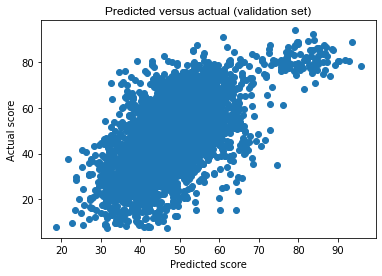

In [377]:
fig, ax = plt.subplots()
plt.scatter(y_pred4,y_val4)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

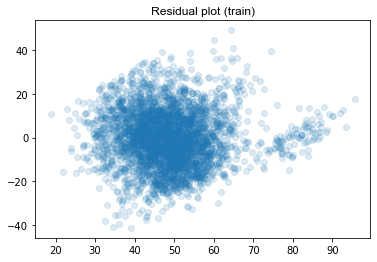

In [378]:
plt.scatter(check4['pred'],check4['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);